Try again with the newly generated geometry with the new FF

In [16]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

import os, sys, shutil
sys.path.append("..")

from lammpsrun import LAMMPS, Prism
from PBSJobSubmissionScript import PBS_Submitter, qstat_monitor
from utility_scripts import *
import pandas as pd

from ase import Atoms, units
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import surface
from ase.spacegroup import crystal, get_spacegroup

cx1_out = r"/rds/general/user/yx6015/home/cx1_out/"
ephemeral = r"/rds/general/user/yx6015/ephemeral/"
sim_path = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/"
potential = "fe_o_water_fe_o_c_5050_water.reax"
print(cx1_out + '\n' + sim_path)

/rds/general/user/yx6015/home/cx1_out/
/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/


In [2]:
# Using data from Ehsan
siderite = crystal(symbols = ['Fe', 'C', 'O'],
                    basis = [(0, 0, 0), 
                             (0, 0, 0.25),
                             (0.2741, 0, 0.25)],
                    spacegroup=167,
                    cellpar=[4.676, 4.676, 15.31, 90, 90, 120])

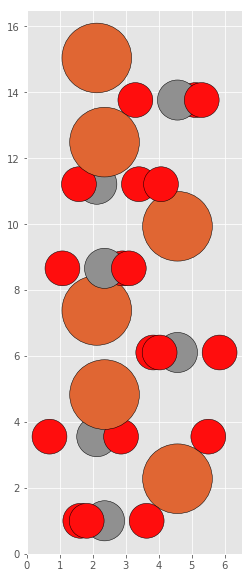

In [3]:
plt.figure(figsize=(18, 10))
plot_atoms(siderite, radii=0.8, rotation=('90x,5y,0z'))
#write("co2_hydration/CO2_solvation.extxyz", CO2_solvation, format = "extxyz")
plt.show()

# Calculating siderite surfaces

In [4]:
# Assuming that the surfaces are identical for 
# structures that are identically labelled
ss_all_names = []

working_dir = os.path.join(sim_path, 'siderite', 'surfaces')
slab_set_files = [x for x in os.listdir(working_dir) if x.endswith('extxyz') and x.startswith('surface')]
slab_set_files_path = [os.path.join(working_dir, x) for x in slab_set_files]
slab_set_files = [x[7:-7] for x in slab_set_files]

for job_name, slab_file in zip(slab_set_files, slab_set_files_path):
    ss_all_names.append(job_name)

    slab_atoms = read(slab_file, format='extxyz')
    slab_calc = reaxff_params_generator(slab_atoms, job_name, write_input=True,
                                        input_fd=os.path.join(sim_path, 'siderite', 'surfaces'),
                                        minimize=["1e-25 1e-25 10000 10000"]*100,
                                        timestep=0.1,
                                        fix=["qeq_reaxc all qeq/reax 1 0.0 10.0 1e-6 reax/c"],
                                        potential=potential)    

ss_input = ["{0}.lammpsin".format(x) for x in ss_all_names]
ss_commands = ["mpiexec lmp_intel_cpu_intelmpi -sf omp -pk omp 4 -in {0} -screen none\n".format(x) for x in ss_input]
ss_source_files = [['$HOME/LAMMPS_Simulation/potentials/{0}'.format(potential),
                    '$PBS_O_WORKDIR/'+x+".lammps*"] for x in ss_all_names]

In [ ]:
import time
num_per_batch = 25

ss_all_out = []
ss_all_err = []

for hour in range(len(ss_input)//num_per_batch+1):
    # an hours delay
    seconds = 3600
    # no sleep on first run
    if hour != 0:
        time.sleep(seconds)
        
    ss_PBS = PBS_Submitter(job_names=ss_all_names[num_per_batch*hour:num_per_batch*(hour+1)],
                           job_commands=ss_commands[num_per_batch*hour:num_per_batch*(hour+1)],
                           modules=["mpi", "lammps/11Aug17", "intel-suite/2017"],
                           walltime="24:00:00",
                           proc_nodes=1,
                           proc_cpus=8,
                           proc_mpiprocs=2,
                           proc_threads=4,
                           memory=32,
                           source_files=ss_source_files[num_per_batch*hour:num_per_batch*(hour+1)])

    curr_dir = os.getcwd()
    
    os.chdir(working_dir)
    ss_out, ss_err = ss_PBS.run()
    os.chdir(curr_dir)
    
    ss_all_out.extend(ss_out)
    ss_all_err.extend(ss_err)
    
ss_all_out

In [8]:
# Move all the log and error files over

for outfile, job_out in zip(ss_all_names, ss_all_out):
    !mv {sim_path}siderite/surfaces/{outfile}.err {ephemeral}{job_out}/
    !mv {sim_path}siderite/surfaces/{outfile}.log {ephemeral}{job_out}/

In [11]:
ss_all_out, len(ss_all_out)

(['2432630.cx1',
  '2432631.cx1',
  '2432632.cx1',
  '2432633.cx1',
  '2432634.cx1',
  '2432635.cx1',
  '2432636.cx1',
  '2432637.cx1',
  '2432638.cx1',
  '2432639.cx1',
  '2432640.cx1',
  '2432641.cx1',
  '2432642.cx1',
  '2432643.cx1',
  '2432644.cx1',
  '2432645.cx1',
  '2432646.cx1',
  '2432647.cx1',
  '2432648.cx1',
  '2432649.cx1',
  '2432650.cx1',
  '2432651.cx1',
  '2432652.cx1',
  '2432653.cx1',
  '2432654.cx1',
  '2432713.cx1',
  '2432714.cx1',
  '2432715.cx1',
  '2432716.cx1',
  '2432717.cx1',
  '2432719.cx1',
  '2432720.cx1',
  '2432721.cx1',
  '2432722.cx1',
  '2432723.cx1',
  '2432724.cx1',
  '2432725.cx1',
  '2432726.cx1',
  '2432727.cx1',
  '2432728.cx1',
  '2432729.cx1',
  '2432730.cx1',
  '2432731.cx1',
  '2432732.cx1',
  '2432733.cx1',
  '2432734.cx1',
  '2432735.cx1',
  '2432736.cx1',
  '2432737.cx1',
  '2432738.cx1',
  '2432808.cx1',
  '2432809.cx1',
  '2432810.cx1',
  '2432811.cx1',
  '2432812.cx1',
  '2432813.cx1',
  '2432814.cx1',
  '2432815.cx1',
  '2432816.cx1

In [12]:
# Checking which runs have completed
ss_valid_names = ss_all_names.copy()
ss_valid_out = ss_all_out.copy()

for outfile, job_out in zip(ss_all_names, ss_all_out):
    err_file_name = os.path.join(ephemeral, job_out, outfile + ".err")
    if os.path.isfile(err_file_name):
        err_file_size = os.path.getsize(err_file_name)
        if err_file_size > 0:
            print(outfile, job_out, ': Terminated with errors')
            ss_valid_names.pop(ss_valid_names.index(outfile))
            ss_valid_out.pop(ss_valid_out.index(job_out))
            
    else:
        print(outfile, job_out, ': File not found')
        ss_valid_names.pop(ss_valid_names.index(outfile))
        ss_valid_out.pop(ss_valid_out.index(job_out))

012_NS_L94 2432648.cx1 : Terminated with errors
101_NS1_L204 2432719.cx1 : Terminated with errors
012_S_L82 2432821.cx1 : Terminated with errors


In [13]:
import pandas as pd
dump_column_names = ['step', 'temp', 'press', 'cpu', 'pxx', 'pyy', 'pzz', 'pxy', 'pxz', 'pyz', 'ke', 'pe', 'etotal', 'vol', 'lx', 'ly', 'lz', 'atoms']
new_column_names = ['surface', 'stoichiometry', 'jobID', 'fileName', 'layers']
ss_all_df = pd.DataFrame(columns=dump_column_names + new_column_names)

for name, out in zip(ss_valid_names, ss_valid_out):
    new_data = dict.fromkeys(new_column_names)
    file_data = name.split('_')
    new_data['surface'] = file_data[0]
    new_data['jobID'] = out
    new_data['fileName'] = name
    new_data['layers'] = int(file_data[-1][1:])
    if len(file_data) == 2:
        new_data['stoichiometry'] = 'NA'
    elif 'N' in file_data[1]:
        new_data['stoichiometry'] = False
    elif 'S' in file_data[1]:
        new_data['stoichiometry'] = True
    else:
        new_data['stoichiometry'] = 'NA'

    log_reader = LAMMPS()
    log_path = os.path.join(ephemeral, out, 'log.lammps')
    if os.path.isfile(log_path):
        log_reader.read_lammps_log(lammps_log=log_path)
        init_data = log_reader.thermo_content[0]
        init_data['step'] = 'initial'
        final_data = log_reader.thermo_content[-1]
        final_data['step'] = 'final'

        ss_all_df = ss_all_df.append({**new_data, **init_data}, ignore_index=True)
        ss_all_df = ss_all_df.append({**new_data, **final_data}, ignore_index=True)

In [14]:
ss_all_df_grouped = ss_all_df.groupby(by=['surface', "stoichiometry"])

Using Hao-Yeh's example:

$$ E_s=\frac{E_{slab}^{n}-n(E_{slab}^{n}-E_{slab}^{n-1})} {2A} $$

While the thickness of slab reaches an adequate value, where the central atom positions are fixed,
$(E^n_{slab} - E^{n-1}_{slab})$ should converge to $𝐸_{bulk}$

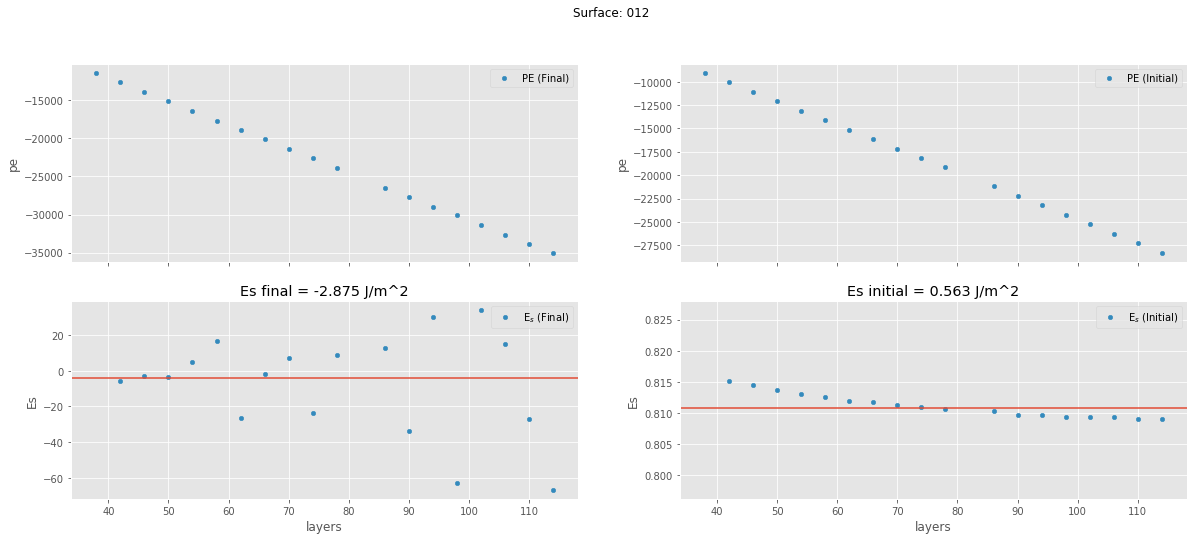

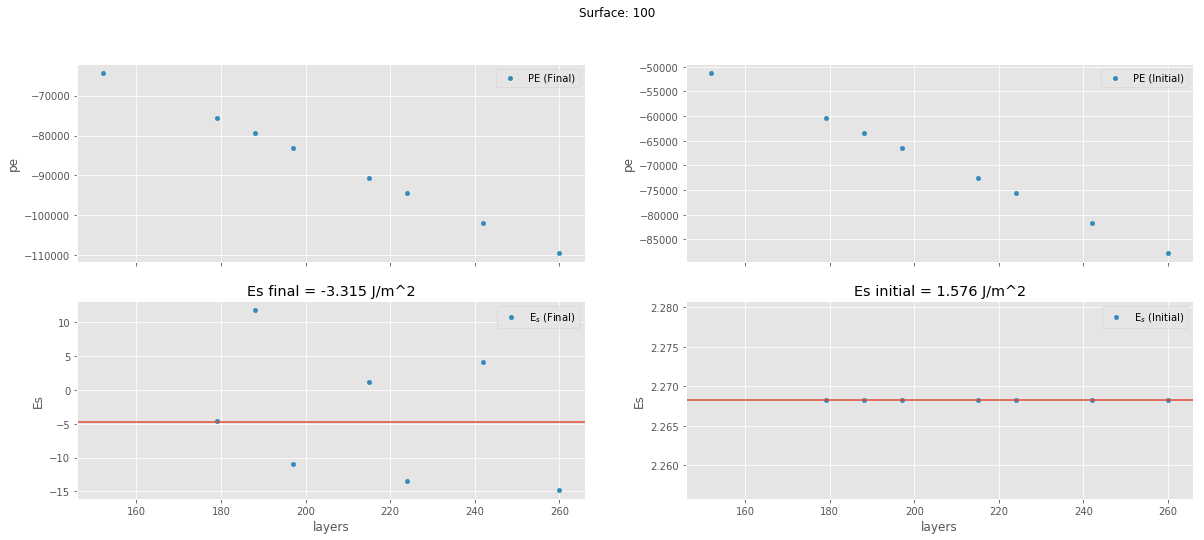

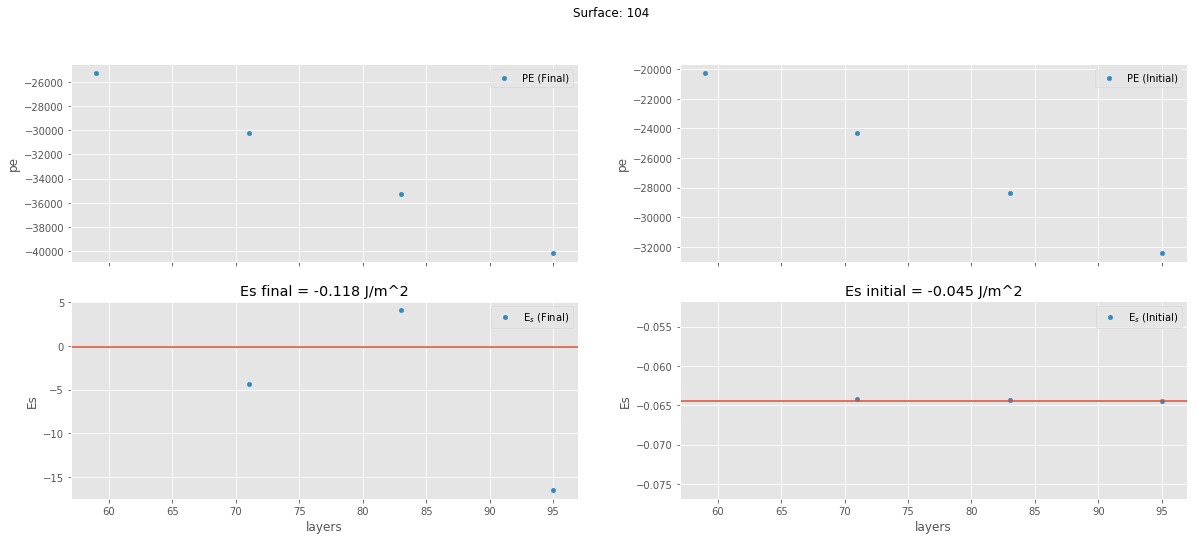

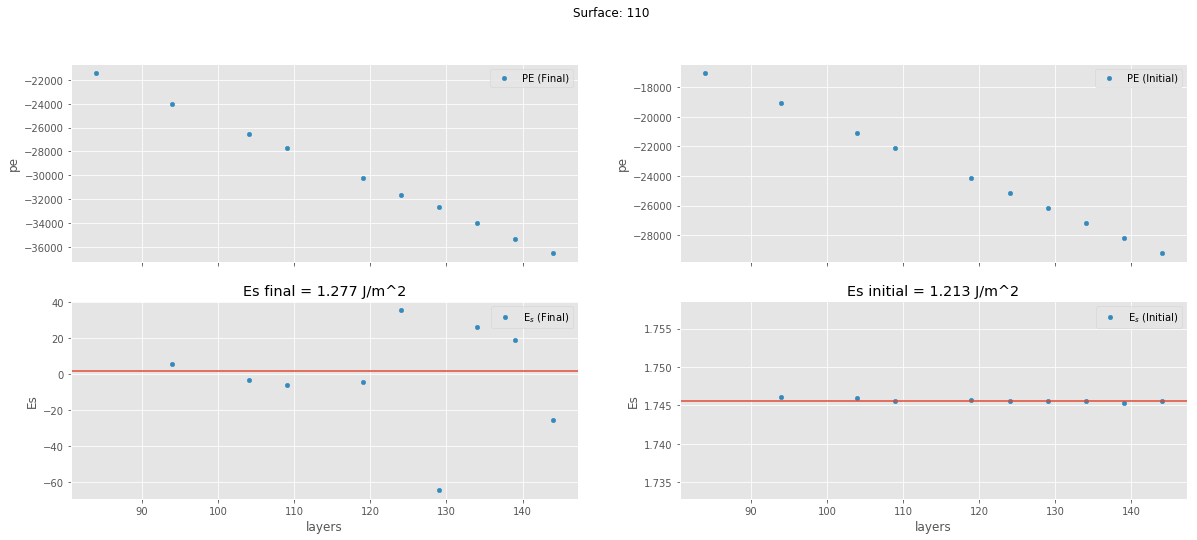

In [17]:
grouped_Es_df = {'initial':[], 'final':[]}
for label, df in ss_all_df_grouped:
    surface = label[0]
    stoichiometry = label[1]
    
    initial_df = df.loc[df.step == 'initial']
    final_df = df.loc[df.step == 'final']
    
    initial_stoic_df = initial_df.loc[initial_df.stoichiometry == True].copy().sort_values('layers').reset_index(drop=True)
    final_stoic_df = final_df.loc[final_df.stoichiometry == True].copy().sort_values('layers').reset_index(drop=True)
    
    initial_stoic_df.layers = pd.to_numeric(initial_stoic_df.layers)
    final_stoic_df.layers = pd.to_numeric(final_stoic_df.layers)
    
    
    initial_stoic_df['area'] = initial_stoic_df.lx * initial_stoic_df.ly
    final_stoic_df['area'] = final_stoic_df.lx * final_stoic_df.ly
    initial_stoic_df['Es'] = (initial_stoic_df.pe - initial_stoic_df.pe.diff() * initial_stoic_df.atoms/initial_stoic_df.atoms.diff()) / (2*initial_stoic_df.area.median())
    final_stoic_df['Es'] = (final_stoic_df.pe - final_stoic_df.pe.diff() * final_stoic_df.atoms/final_stoic_df.atoms.diff()) / (2*final_stoic_df.area.median())
        
    if (len(final_stoic_df.layers)) > 0:
        f, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2, 2, figsize=(20, 8), sharex=True)
        final_stoic_df.plot.scatter(x='layers', y='pe', ax = ax00, label='PE (Final)')
        initial_stoic_df.plot.scatter(x='layers', y='pe', ax = ax01, label='PE (Initial)')

        final_stoic_df.plot.scatter(x='layers', y='Es', ax = ax10, label='E$_s$ (Final)')
        initial_stoic_df.plot.scatter(x='layers', y='Es', ax = ax11, label='E$_s$ (Initial)')
        
        Es_mean_init = initial_stoic_df.Es[abs(initial_stoic_df.Es - initial_stoic_df.Es.mean()) < initial_stoic_df.Es.std()].mean()
        Es_mean_final = final_stoic_df.Es[abs(final_stoic_df.Es - final_stoic_df.Es.mean()) < final_stoic_df.Es.std()].mean()

        grouped_Es_df['initial'].append(initial_stoic_df.copy())
        grouped_Es_df['final'].append(final_stoic_df.copy())
        # convert units
        Es_mean_init_Jm2 = Es_mean_init * units.kcal / units.mol / units.J * (units.m)**2
        Es_mean_final_Jm2 = Es_mean_final * units.kcal/units.mol / units.J * (units.m)**2
        
        ax10.axhline(Es_mean_final)
        ax10.set_title('Es final = {:.3f} J/m^2'.format(Es_mean_final_Jm2))
        ax11.axhline(Es_mean_init)
        ax11.set_title('Es initial = {:.3f} J/m^2'.format(Es_mean_init_Jm2))
        
        f.suptitle('Surface: ' + final_stoic_df.surface[0])
        #f.tight_layout()
        f.show()